# Plot full record of Mauna Loa in-situ data

For bold labels and tick labels, latex needs to be installed.
See https://matplotlib.org/stable/tutorials/text/usetex.html

Matplotlib’s LaTeX support requires a working LaTeX installation, 
dvipng (which may be included with your LaTeX installation), and 
Ghostscript (GPL Ghostscript 8.60 or later is recommended). 
The executables for these external dependencies must all be 
located on your PATH.

To install Latex: https://www.latex-project.org/get/

Create python virtual environment and install:
pandas, numpy, and matplotlib

## Load in Scripps CO2 Program Github Repository

In [84]:
import os
os.chdir('/content')
CODE_DIR = 'scrippsco2_notebooks'

In [85]:
!git clone https://github.com/lmerchant/scrippsco2_notebooks.git $CODE_DIR
%cd $CODE_DIR

fatal: destination path 'scrippsco2_notebooks' already exists and is not an empty directory.
/content/scrippsco2_notebooks


In [86]:
# get modifications made on the repo
!git pull origin main

From https://github.com/lmerchant/scrippsco2_notebooks
 * branch            main       -> FETCH_HEAD
Already up to date.


In [87]:
%matplotlib inline
import requests
from google.colab import files
import pandas as pd
import numpy as np
import pathlib
from datetime import datetime, date
# import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# from matplotlib import ticker
from matplotlib import rc,rcParams

### Configure the following to use Latex fonts

In [88]:
rc('text', usetex=True)
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

### Load in plotting functions

In [89]:
from utils import get_dates, configure_plots

### Set directories and file names for data,  plot, and logo

In [90]:
insitu_data_dir = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/'

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

logo_dir = './images'
logo_file  = pathlib.Path(logo_dir) /  'sio_logo.png'

In [91]:
# TODO
# Read in data from website

monthly_mlo = 'monthly/monthly_in_situ_co2_mlo.csv'
data_file = f"{insitu_data_dir}/{monthly_mlo}" 

pdf_file = plot_dir / 'mlo_record.pdf'
png_file = plot_dir / 'mlo_record.png'

### Get today's date

In [92]:
todays_date_moyr, todays_date_modyyr, today_decimal, todays_year = get_dates.get_todays_date()

### Set plot limits and text

In [93]:
xmin = 1957
xmax = todays_year + 2

ymin = 310
ymax = 425

In [94]:
xlabel = 'Year'
ylabel = 'CO$_2$ Concentration (ppm)'

title1 = 'Mauna Loa Observatory, Hawaii'
title2 = 'Monthly Average Carbon Dioxide Concentration'
title3 = f'Data from Scripps CO$_2$ Program     Last updated {todays_date_moyr}'

## Load in Data and process

### Fix bad security certificate for scrippsco2.ucsd.edu

In [95]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [96]:
df = pd.read_csv(data_file,sep=',',comment='"')
df.head()

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44


### Remove next two rows containing header information and change to numeric vals

In [97]:
df = df.iloc[2:]
df = df.apply(pd.to_numeric)

### Rename column names to replace duplicate names

In [98]:
col_mapping ={df.columns[0]:'year', df.columns[1]: 'month', df.columns[2]: 'excel_date', 
              df.columns[3]: 'dec_date', df.columns[4]: 'co2', df.columns[5]: 'co2_seasonal',
              df.columns[6]: 'co2_fit', df.columns[7]: 'co2_seasonal_fit', 
              df.columns[8]:'co2_filled', df.columns[9]: 'co2_seasonal_filled'}
df = df.rename(columns=col_mapping)
df.head()

,year,month,excel_date,dec_date,co2,co2_seasonal,co2_fit,co2_seasonal_fit,co2_filled,co2_seasonal_filled
2,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44
5,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
6,1958,5,21320,1958.3699,317.51,314.71,317.87,315.07,317.51,314.71


### Break into 2 dataframes. One for CO2 and one for the CO2 spline
The decimal date is the midpoint of each month

In [99]:
df_co2 = df[['dec_date', 'co2']].copy()
df_co2_spline = df[['dec_date', 'co2_fit']].copy()

### Remove CO2 rows and CO2 spline rows with fill values -99.99

In [100]:
df_co2 = df_co2[df_co2['co2'] != -99.99]
df_co2_spline = df_co2_spline[df_co2_spline['co2_fit'] != -99.99]

### Convert to numpy arrays for plotting

In [101]:
date_co2 = df_co2['dec_date'].to_numpy()
co2 = df_co2['co2'].to_numpy()
date_co2_spline = df_co2_spline['dec_date'].to_numpy()
co2_spline = df_co2_spline['co2_fit'].to_numpy()

# Create  Plot

### Set plot properties, add logo, and save to png and files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

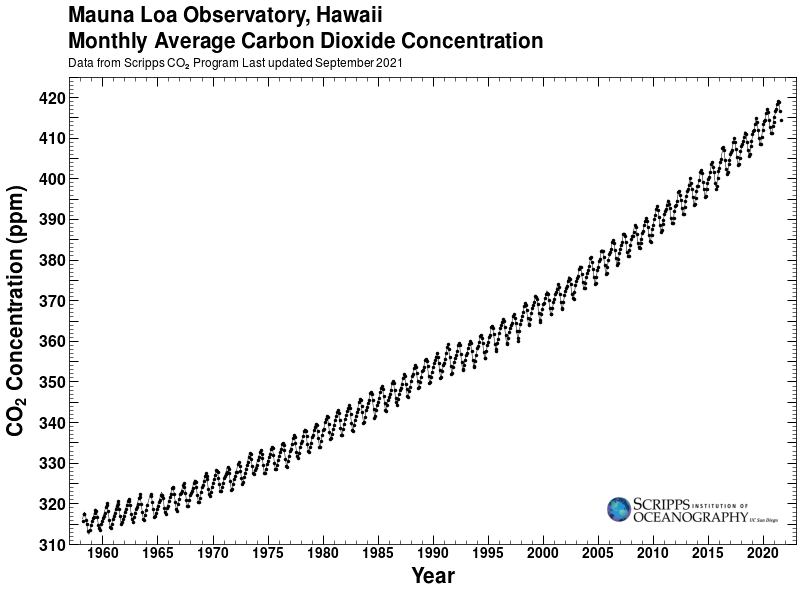

In [109]:
fig = plt.figure()
ax = fig.add_subplot()

# -------------
# Plot the data
# -------------

ax.plot(date_co2, co2, 'o', color='black',
         markersize=3.5, linewidth=1,
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=0)

ax.plot(date_co2_spline, co2_spline, '-', color='black', linewidth=0.5)


# -------------------
# Set plot properties
# -------------------
configure_plots.set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel)

# ---------------
# Add plot titles
# ---------------
configure_plots.add_3_plot_titles(ax, title1, title2, title3)

# --------------------
# Add SIO logo to plot
# --------------------
configure_plots.add_sio_logo(logo_file, fig)


# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()


configure_plots.save_plot_for_website(fig, pdf_file, png_file)

#files.download(pdf_file)

plt.show()

In [106]:
!ls plots

mlo_record.pdf	mlo_record.png
